# Getting started with using FeedbackParticleFilters.jl

In [1]:
using FeedbackParticleFilters
using Distributions
using PyPlot

┌ Info: Recompiling stale cache file /home/simone/.julia/compiled/v1.1/FeedbackParticleFilters/KhkEf.ji for FeedbackParticleFilters [f4440bb6-80da-11e9-1db0-85cc1897f664]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/simone/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


## Setting up a filtering problem

Here, we set up a basic one-dimensional linear-Gaussian continuous-time filtering problem:

$$ dX_t = -X_t dt + \sqrt{2} dW_t, \quad X_0\sim\mathcal{N}(0,1), $$
$$ dY_t = X_t dt + dV_t. $$

In [2]:
state_model = ScalarDiffusionStateModel(x->-x, x->sqrt(2.), Normal())
obs_model = ScalarDiffusionObservationModel(x->x)

filt_prob = ContinuousTimeFilteringProblem(state_model, obs_model);

## Initializing particle ensembles

The following line initializes a feedback particle filter ensemble of size $N=100$ for the scalar diffusion model `state_model` above. 
This means that the individual particles are scalar real numbers, i.e. of type `Float64`. 
The particle positions are randomly initialized from the initial distribution provided in `state_model`.

In [12]:
ensemble = FPFEnsemble(state_model, 100)

FPFEnsemble{Float64}([-0.795288, 1.4443, 1.10514, -0.546197, -0.361685, 1.71221, 1.65366, -0.568192, -1.31576, 1.64184  …  1.36034, -1.44697, -0.493915, -0.0259679, 1.09804, 1.49111, 1.41401, -1.49327, -0.690999, 1.31105], 100)

## Computing (estimating) the gain

Once an ensemble is initialized, the FPF gain has to be computed.
The constructor for `GainEquation` (itself an abstract type) constructs an appropriate equation for the provided observation model.

In [24]:
eq = GainEquation(state_model, obs_model, ensemble);

In the case of `obs_model` defined above, this is a scalar Poisson equation:

In [25]:
typeof(eq)

ScalarPoissonEquation


The `ScalarPoissonEquation` object encapsulates the data provided by the models, such as the observation function.
In addition, it contains the fields `potential` and `gain` for the solution of the gain equation and its gradient respectively, at the particle locations.
They are initialized with ones and zeros respectively.

Calling `Solve!` with an appropriate gain estimation method will fill in the `potential` and `gain` fields:

In [26]:
method = SemigroupMethod1d(1E-1, 1E-2, 1000)
@time Solve!(eq, method);

  0.014199 seconds (117 allocations: 241.813 KiB)


The solution may be visualised as follows:

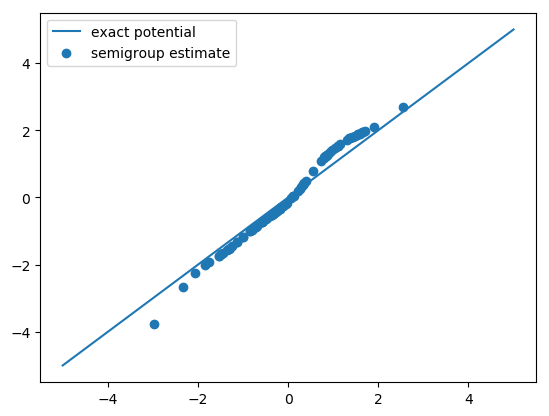

In [27]:
plot([x for x in -5:.1:5], [x for x in -5:.1:5])
scatter(eq.positions, eq.potential);
legend(("exact potential","semigroup estimate"));

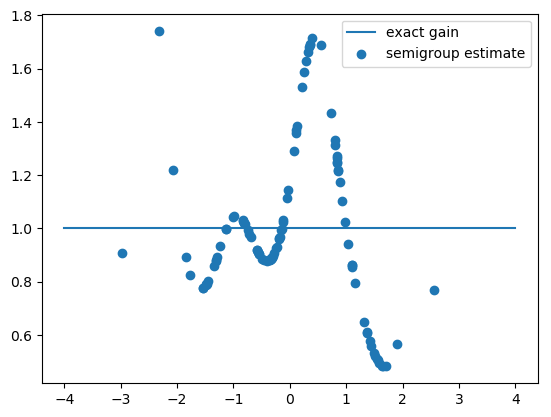

In [28]:
#ylim([0,2])
plot([x for x in -4:.1:4], [1 for x in -4:.1:4])
scatter(eq.positions, eq.gain);
legend(("exact gain","semigroup estimate"));

## Running simulations

Above, we looked at the gain estimation step, which is crucial for FPFs. 
But running a feedback particle filter simulation involves prediction as well as simulation of the hidden state and observation processes.
This is fully implemented in FeedbackParticleFilters.jl.

First, we define the filter to be run.
In this case, we use `N = 100` particles and we use the regularized semigroup method.

In [46]:
method = RegularizedSemigroupMethod1d(1E-1, 1E-2, 1000, 1E-3)
filter = FeedbackParticleFilter(filt_prob, method, 100);

Then we set up a simulation for the filter for `n_time = 1000` time steps and a time discretization of `dt = 0.01`.

In [47]:
simulation = FPFSimulation(filter, 1000, 0.01);

Calling `run!` will perform the full simulation.
To monitor progress, a dot is shown every 100 time steps.

In [48]:
@time run!(simulation)

Starting simulation......!!!!....DONE.
  0.343493 seconds (1.40 M allocations: 225.170 MiB, 2.70% gc time)


In addition to the ten dots, we also see some exclamation marks `!`.
An exclamation marks indicates that there was a time step in which the gain estimation did not converge within the `1000` iterations we provided.
This means that the gain that was used was suboptimal. 
If it happens only a handful of times during the course of `1000` time steps, this should not affect the filter performance too much.
In this case, increasing the number of iterations to `10000` solves the problem without significantly affecting simulation time.

In [51]:
method = RegularizedSemigroupMethod1d(1E-1, 1E-2, 10000, 1E-3)
filter = FeedbackParticleFilter(filt_prob, method, 100);
simulation = FPFSimulation(filter, 1000, 0.01);
@time run!(simulation)

Starting simulation..........DONE.
  0.367765 seconds (1.43 M allocations: 252.145 MiB, 2.93% gc time)


### Recording simulation trajectories

Normally, the simulation is run without storing any intermediate values, such as the particle positions for intermediate time steps.
In order to record intermediate values, we can define a custom data type which contains the fields which we wish to store.
Those fields have to be fieldnames of the `FPFSimulation` data structure:

In [52]:
fieldnames(FPFSimulation)

(:n_time, :dt, :propagate!, :emit, :update!, :state, :observation, :ensemble, :eq)

As an example, the following defines a data type that will store the hidden state and the particle ensemble for each time step (the naming does not matter): 

In [53]:
struct record
    state
    ensemble
end

Calling `run!` with an additional parameter equal to the data type just defined will return an array containing all the records:

In [54]:
method = RegularizedSemigroupMethod1d(1E-1, 1E-2, 10000, 1E-3)
filter = FeedbackParticleFilter(filt_prob, method, 100);
simulation = FPFSimulation(filter, 10000, 0.01);
@time records = run!(simulation, record);

Starting simulation....................................................................................................DONE.
  3.335644 seconds (14.87 M allocations: 2.441 GiB, 4.77% gc time)


In [55]:
typeof(records)

Array{record,1}

We may now visualize the hidden state and filter trajectory:

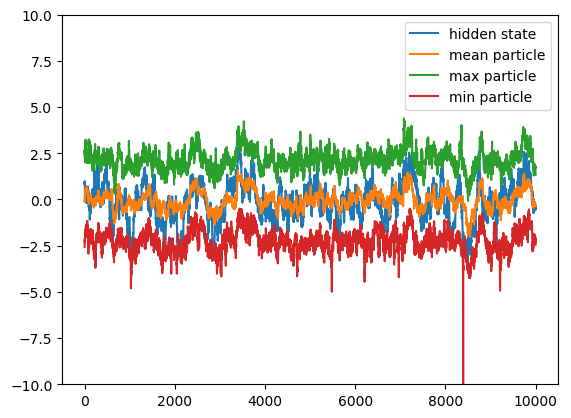

In [58]:
nn = 1:10000
ylim([-10,10])
plot([rec.state for rec in records[nn]]);
plot([mean(rec.ensemble.positions) for rec in records[nn]]);
plot([maximum(rec.ensemble.positions) for rec in records[nn]]);
plot([minimum(rec.ensemble.positions) for rec in records[nn]]);
legend(("hidden state","mean particle","max particle","min particle"));

We can then evaluate the mean-squared error of the particle estimate...

In [59]:
MSE(records)

0.7602747145095684

...or the relative mean-squared error (i.e. MSE normalized by the prior variance):

In [61]:
RelativeMSE(records)

0.684854016151668

### Recording further simulation details for troubleshooting

Sometimes it may be necessary to record further details about the simulation, for example the gain equation objects for gain estimation, in order to troubleshoot problems with the filtering algorithm.

Here, we include the `eq` field of the simulation in addition to the previous two fields:

In [62]:
mutable struct anotherrecord
    state
    ensemble
    eq
end

Let's run a slightly shorter simulation in order to see this in action:

In [63]:
simulation2 = FPFSimulation(filter, 1000, 0.01);
@time records2 = run!(simulation2, anotherrecord);

Starting simulation..........DONE.
  0.427648 seconds (1.67 M allocations: 254.196 MiB, 5.04% gc time)


These are the simulated trajectories:

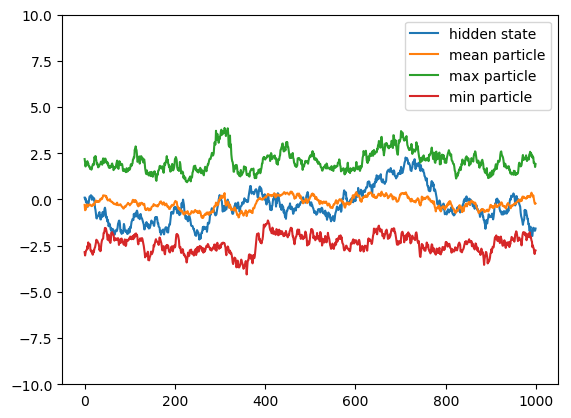

In [66]:
nn = 1:1000
ylim([-10,10])
plot([rec.state for rec in records2[nn]]);
plot([mean(rec.ensemble.positions) for rec in records2[nn]]);
plot([maximum(rec.ensemble.positions) for rec in records2[nn]]);
plot([minimum(rec.ensemble.positions) for rec in records2[nn]]);
legend(("hidden state","mean particle","max particle","min particle"));

Since we included the `eq` field in the recording, we can now do things such as displaying all the gain estimates at once:

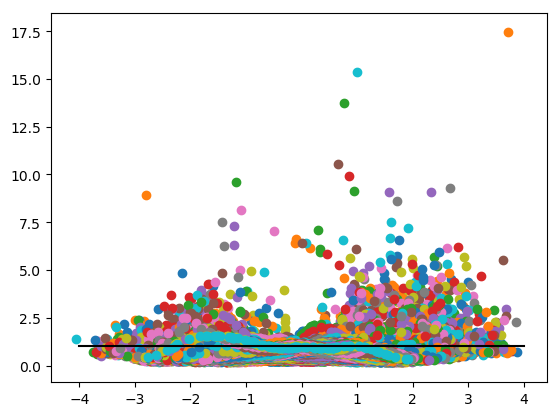

In [67]:
plot([x for x in -4:.1:4], [1 for x in -4:.1:4], color="black")
for i in 1:1000
    scatter(records2[i].ensemble.positions, records2[i].eq.gain);
end